# COVID-19 Contextual Analysis with Bidirectional Encoder Representations from Transformers (BERT)

# Goal

Clustering the contents of the data set provided by COVID-19 Open Research Dataset using Bidirectional Encoder Representations from Transformers (BERT).

The metadata.csv was used for the analysis. The file contains metadata for more than 28,000 documents. The file includes two important fields. These are abstract and titel fields.  Help of these two fields of documents has been created an text body, which was embedded in a single vector space using BERT.

The solution of the problem is based on the idea that the elements of the embedded vector space formed from the text body of documents define the content of the text more precisely than the methods based on the document matrix. Therefore, clustering performed on such a body of text can more accurately show the content distribution of documents.

Furthermore plan was that, let each cluster is labeled with keywords. 

Part of the solution is the source code written in python and all the outputs of the solver program as well.

# Approach

1. Data preparation (Loading, cleaning...)
3. Body text embedding with BERT
4. Dimension reduction with PCA
5. Application of the K-elbow method to define optimal cluster number
6. Clustering with K-mean algorithm
7. To define the topic words to the clusters
8. Saveing data
9. Visualizing data with PCA and t-SNE using projector.tensorflow.org

# Table of Contents

1. Loading the Data
2. Remove 'Abstract' text all of front of abstract contents
3. Text cleaning
4. Define the most common words in abstracts
5. Create embedding vectors with BERT
6. Calculate the best size of PCA dimension
7. Reduction to 200 dimensions is seem good choice
8. Define the optimal cluster number
9. Create clusters using k-mean algorithm
10. To genearte topic words to clusters with LDA analysis
11. To genearte .tsv files for 'projector.tensorflow.org'

# References

[[1.] Stemming](https://en.wikipedia.org/wiki/Stemming#cite_note-1)

[[2.] Lemmatisation](https://en.wikipedia.org/wiki/Lemmatisation)

[[3.] Bidirectional Transformers forLanguage Understanding (BERT)](https://arxiv.org/pdf/1810.04805.pdf)

[[4.] Principal component analysis (PCA)](https://www.tandfonline.com/doi/abs/10.1080/14786440109462720#aHR0cHM6Ly93d3cudGFuZGZvbmxpbmUuY29tL2RvaS9wZGYvMTAuMTA4MC8xNDc4NjQ0MDEwOTQ2MjcyMD9uZWVkQWNjZXNzPXRydWVAQEAw)

[[5.] Elbow method (clustering)](https://en.wikipedia.org/wiki/Elbow_method_(clustering)

[[6.] k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering#cite_note-lloyd19572-4)

[[7.] Document-term matrix](https://en.wikipedia.org/wiki/Document-term_matrix)

[[8.] Latent Dirichlet Allocation (LDA)](https://web.archive.org/web/20120207011313/http://jmlr.csail.mit.edu/papers/volume3/blei03a/blei03a.pdf)

[[9.] t-distributed stochastic neighbor embedding (t-SNE)](http://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)

[[10.] projector.tensorflow.org](https://projector.tensorflow.org/)

*Loading the Data*

New dataset has been created from original covid-19 nlp dataset using Excell. It includes an filtered metadata file (COVID-19-ORDC-cleaned-metadata.xlsx). The file consist of only such as records which abstract field of records longer than 200 character.

[NEW DATASET](https://www.kaggle.com/robertlakatos/covid19-ordc-cleaned-metadata)

In [5]:
import pandas as pd

path_data = "../input/covid19-ordc-cleaned-metadata/COVID-19-ORDC-cleaned-metadata.xlsx"
data = pd.read_excel(path_data)

print("Metadata was read. Total number of rows in file: " + str(len(data["title"])))

Metadata was read. Total number of rows in file: 28392


*Remove 'Abstract' text all of front of abstract contents*

Every abstract field in the dataset start with an 'Abstract' text. It is an irrelevant information so it has to remove from every fields.

In [7]:
path_output_data = "/kaggle/working/COVID-19-ORDC-cleaned-metadata-extended.xlsx"

cleared_abstract = []
for abstract in data["abstract"]:

    if abstract[:8] == "Abstract":
        abstract = abstract[9:]

    cleared_abstract.append(abstract)
data["abstract"] = cleared_abstract

data.to_excel(path_output_data, index=False)

print("'Abstract' text removed")

'Abstract' text removed


*Text cleaning*

A function ('clean_text') has been defined which clean the body text.

Tasks of the function  are as follows:
* To lower
* Remove punctuations
* Remove special characters and digits
* Stemming
* Lemmatisation

In [8]:
import re
import nltk

stop_words = set(nltk.corpus.stopwords.words("english"))

def clean_text(text):
    # To lower
    result = text.lower()
    # Remove punctuations
    result = re.sub('[^a-zA-Z]', ' ', result)
    # remove special characters and digits
    result = re.sub("(\\d|\\W)+", " ", result)
    # convert to list from string
    result = result.split()
    # [1.] Stemming
    ps = nltk.stem.porter.PorterStemmer()
    # [2.] Lemmatisation
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    result = [lem.lemmatize(word) for word in result if not word in stop_words]

    return " ".join(result)

*Define the most common words in abstracts*

The program has to calculate the most common words because these words need to the body text embedding.

In [10]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(stop_words='english')

common_words = []
for abstract in data["abstract"]:
    abstract = [clear_text(abstract)]
    count_data = count_vectorizer.fit_transform(abstract)
    words = count_vectorizer.get_feature_names()
    tmp = words[::-1]
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts += t.toarray()[0]
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x: x[1], reverse=True)[0:20]
    words = [w[0] for w in count_dict]
    common_words.append(" ".join(words))


data["common_words"] = common_words

data.to_excel(path_output_data, index=False)

print("The most common words was defined")

The most common words was defined


*Create embedding vectors with BERT*

The BERT system will be used to embed the texts.

The steps is follows:
1. Read a record
2. Split the text of the abstract field to sentences
3. Tokenize the sentences with BERT tokenizer
4. Encode the sentences with BERT encoder
5. Fit the sentence with BERT
6. Collect the most common and title words's vectors from BERT's embedding layer
7. Calculate mean of the vectors
8. Repeat these steps on all records

In [13]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')

len_data = len(data["abstract"])
vectors = [""]*(len_data)

for i in range(0, len_data):
    try:
        # collect sentence and common words
        sentences = data["abstract"][i].split(". ")
        common_words = data["common_words"][i].split(" ")
        
        # tokenize with BERT [3] tokenizer
        encoded_sentences = []
        tokenized_sentences = []
        for sentence in sentences:
            sentence = sentence[:512]
            encoded_sentences.append(tokenizer.encode(sentence))
            tokenized_sentences.append(tokenizer.tokenize(sentence))

        index_sentences = []
        for sentence in tokenized_sentences:
            index_sentence = []
            for word in common_words:
                try:
                    tmp = sentence.index(word)
                    index_sentence.append(tmp+1)
                except:
                    continue
            index_sentences.append(index_sentence)
        
        # Create embedded vectors with BERT [3]
        abstract_vectors = tf.constant([[0]*768]).numpy()
        for j in range(0,len(encoded_sentences)):
            if len(index_sentences[j]) != 0:
                input_ids = tf.constant(encoded_sentences[j])[None, :]
                outputs = model(input_ids)
                sentence_vectors = outputs[0][0]
                sentence_vectors = sentence_vectors.numpy()
                len_isj = len(index_sentences[j])
                sentence_vectors_collected = [[0]*768] * len_isj
                for n in range(0,len_isj):
                    sentence_vectors_collected[n] = sentence_vectors[index_sentences[j][n]]

                abstract_vectors = np.concatenate((abstract_vectors, sentence_vectors_collected), axis=0)

        encoded_title = tokenizer.encode(data["title"][i])
        input_ids = tf.constant(encoded_title)[None, :]
        outputs = model(input_ids)
        title_vectors = outputs[0][0]
        title_vectors = title_vectors[1:len(title_vectors)-1].numpy()
        abstract_vectors = np.concatenate((abstract_vectors, title_vectors), axis=0)

        vektor = tf.reduce_mean(abstract_vectors, 0).numpy()
        vectors[i] = "\t".join(map(str, vektor))

        # chekpoint
        if (i % 1000) == 0 and i != 0:
            data["vectors"] = vectors
            data.to_excel(path_output_data, index=False)
            print("Processed data: " + str(i))
    except: 
        continue

data["vectors"] = vectors
data.to_excel(path_output_data, index=False)

print("Processed data: " + str(i))
print("The Embedded vectors was created")

The Embedded vectors was created


*Calculate the best size of PCA [4] dimension*

To speed it up the calculation the program calculate the variance. Keep the variance of 90 % is an good choose to properly number of dimensions.

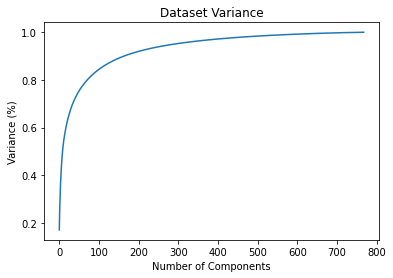

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Read vectors
number_of_vectors = len(data["vectors"])
vectors = np.array([[0]*768]*number_of_vectors, dtype=float)
for i in range(0, number_of_vectors):
    vector = data["vectors"][i].split("\t")
    vectors[i] = np.array(vector, dtype=float)

# Scale vectors
scaler = MinMaxScaler(feature_range=[0, 1])
vectors = scaler.fit_transform(vectors)

# Fitting the PCA [4] algorithm on data
pca = PCA().fit(vectors)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Dataset Variance')
plt.show()

*Reduction to 200 dimensions seems like a good choice*

In [16]:
pca = PCA(n_components=200)
vectors = pca.fit_transform(vectors)

print("PCA is on")

PCA is on


*Define the optimal cluster number*

To determine the optimal number of clusters with k-elbow [5] method. Ideal point on curve will be correct cluster number. This point is that where the distortion start decreasing in a linear fashion.

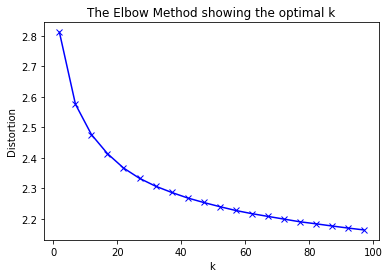

In [17]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler

distortions = []
maxK = 100
K = range(2, maxK, 5)
for k in K:
    kmeanModel = KMeans(n_clusters=k, verbose=0)
    kmeanModel.fit(vectors)
    distortions.append(sum(np.min(cdist(vectors, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / vectors.shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

*Create clusters using k-mean [6] algorithm*

Any cluster number between 15 and 40 seems like a good choice.

In [18]:
kmeanModel = KMeans(n_clusters=15,
                    verbose=0)
kmeanModel.fit(vectors)

data["clusters"] = kmeanModel.labels_
data.to_excel(path_output_data, index=False)

print("Custering completed")

Custering completed


*To genearte topic words to clusters with LDA analysis*

Each cluster can be treated as a set of different topics. LDA [8] is suitable for finding words that characterize different topics.

In [19]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

pd.options.mode.chained_assignment = None

number_of_documents = len(data["title"])
data["words_of_topic_in_clusters"] = [""]*number_of_documents
data_grouped = data.groupby(['clusters'])
for key in data_grouped.groups:
    group = data_grouped.groups[key]
    texts = []
    for index in group:
        text = clear_text(data["title"][index] + " " + data["abstract"][index])
        texts.append(text)
    
    # Create document matrix [7]
    count_vectorizer = CountVectorizer(stop_words='english')
    count_data = count_vectorizer.fit_transform(texts)    
    words = count_vectorizer.get_feature_names()

    number_topics = 1
    number_words = 10
    lda = LDA(n_components=number_topics, verbose=0)
    lda.fit(count_data)

    lda_words = " ".join([words[i] for i in lda.components_[0].argsort()[:-number_words - 1:-1]])
    for index in group:
        data["words_of_topic_in_clusters"][index] = lda_words

data.to_excel(path_output_data, index=False)
print("LDA completed")

LDA completed


*To genearte .tsv files for 'projector.tensorflow.org' [10]*

projector.tensorflow.org is an very usefull and simple online visualizaton tool from Google. We can make PCA [4] and t-SNE [9] analyzis on our data easy way with this tool. projector.tensorflow.org works with .tsv file format so before using the projector have to creat these files. The visualizaton  tool use two files. These are the meta and vectors. The vectors contains data vectors and the meta contains data describing the vectors.

In [21]:
number_of_documents = len(data["title"])
f_vecs = open("/kaggle/working/vecs.tsv","w",encoding="utf8")
f_meta = open("/kaggle/working/meta.tsv","w",encoding="utf8")
f_meta.write("title\tclusters\twords_of_topic\n")
for i in range(0, number_of_documents):
    f_vecs.write(data["vectors"][i] + "\n")
    f_meta.write(data["title"][i] + "\t" + str(data["clusters"][i]) + "\t" + data["words_of_topic_in_clusters"][i] + "\n")
f_vecs.close()
f_meta.close()

print(".tsv files creating completed")

.tsv files creating completed
